## PSD Frequency Band Analysis Notebook

Needs:
- PSD data



**Load the PSD data**

In [21]:
from pathlib import Path
import pandas as pd

data_dir = Path('/Users/fdjim/Desktop/PDS_CODE/periodogram')
psd_hc_path = data_dir / 'psd_data_hc.csv'
psd_mdd_path = data_dir / 'psd_data_mdd.csv'
psd_sz_path = data_dir / 'psd_data_sz.csv'

# Read individual dataframes
df_hc = pd.read_csv(psd_hc_path)
df_mdd = pd.read_csv(psd_mdd_path)
df_sz = pd.read_csv(psd_sz_path)

# Add group column to each dataframe
df_hc['group'] = 'HC'
df_mdd['group'] = 'MDD'
df_sz['group'] = 'SZ'

# Combine into master dataframe
df_master = pd.concat([df_hc, df_mdd, df_sz], ignore_index=True)
# Reorder columns to put 'group' first
cols = ['group'] + [col for col in df_master.columns if col != 'group']
df_master = df_master[cols]

# Optional: Display first few rows to verify
df_master.head()

,group,subject,roi,freq_0.000000,freq_0.001603,freq_0.003205,freq_0.004808,freq_0.006410,freq_0.008013,freq_0.009615,...,freq_0.235577,freq_0.237179,freq_0.238782,freq_0.240385,freq_0.241987,freq_0.243590,freq_0.245192,freq_0.246795,freq_0.248397,freq_0.250000
0,HC,sub-006C,auditory,0.008015,0.005792,0.000746,0.003023,0.015990,0.568427,2.321314,...,3.736047,1.663963,1.097691,0.497735,0.094331,0.003849,0.001997,0.002015,0.002083,0.001041
1,HC,sub-006C,dmn,0.011662,0.010409,0.000750,0.002002,0.014896,0.165612,1.607802,...,1.675639,1.932842,0.963458,0.492616,0.121158,0.002242,0.001486,0.001633,0.001647,0.000822
2,HC,sub-006C,fpn,0.022656,0.022103,0.001804,0.002101,0.029962,0.174830,2.137338,...,1.598491,1.044093,0.486502,0.429055,0.131478,0.003553,0.001275,0.001617,0.001653,0.000827
3,HC,sub-006C,limbic,0.004164,0.003214,0.000255,0.003876,0.020979,0.547795,2.699949,...,2.652705,3.345829,2.751931,1.750267,0.151471,0.005901,0.001111,0.001040,0.001039,0.000517
4,HC,sub-006C,motor,0.008699,0.007647,0.000300,0.001335,0.020151,0.138396,0.753515,...,4.196818,1.235074,0.909866,0.698679,0.070798,0.001502,0.002021,0.002121,0.002148,0.001071


**Commpute mean power for each group and each region**


In [38]:
def compute_mean_spectrum(df):
    """
    Compute mean frequency spectrum for each group and region.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The master PSD dataframe
        
    Returns:
    --------
    dict of DataFrames
        Contains mean spectrum for each group, indexed by frequency
    """
    # Get frequency columns
    freq_cols = [col for col in df.columns if col.startswith('freq_')]
    
    # Group by 'group' and 'roi' and compute mean for all frequency columns
    mean_spectra = df.groupby(['group', 'roi'])[freq_cols].mean().reset_index()
    
    # Convert frequencies to numeric values for plotting
    freq_values = [float(col.replace('freq_', '')) for col in freq_cols]
    
    # Create separate DataFrames for each group
    group_spectra = {}
    for group in df['group'].unique():
        group_data = mean_spectra[mean_spectra['group'] == group]
        
        # Create DataFrame with frequencies as index
        spectrum_df = pd.DataFrame(
            group_data[freq_cols].values.T,
            index=freq_values,
            columns=group_data['roi']
        )
        group_spectra[group] = spectrum_df
    
    return group_spectra

mean_spectra = compute_mean_spectrum(df_master)
mean_spectra['HC']

roi,auditory,dmn,fpn,limbic,motor,salience,visual
0.000000,0.033614,0.034736,0.024515,0.027891,0.030020,0.035197,0.033370
0.001603,0.029787,0.031478,0.022053,0.025229,0.027508,0.031349,0.029910
0.003205,0.002149,0.002485,0.001787,0.001993,0.002193,0.002249,0.002435
0.004808,0.003666,0.004722,0.005077,0.004357,0.004384,0.004593,0.004930
0.006410,0.030240,0.034768,0.059697,0.027667,0.031134,0.040538,0.044770
...,...,...,...,...,...,...,...
0.243590,0.004729,0.003449,0.003086,0.006127,0.004097,0.004920,0.002399
0.245192,0.001112,0.001039,0.000891,0.001979,0.001230,0.001260,0.000543
0.246795,0.001052,0.000961,0.000844,0.001883,0.001183,0.001172,0.000493
0.248397,0.001044,0.000948,0.000831,0.001850,0.001171,0.001162,0.000485


/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_15063/3222684312.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


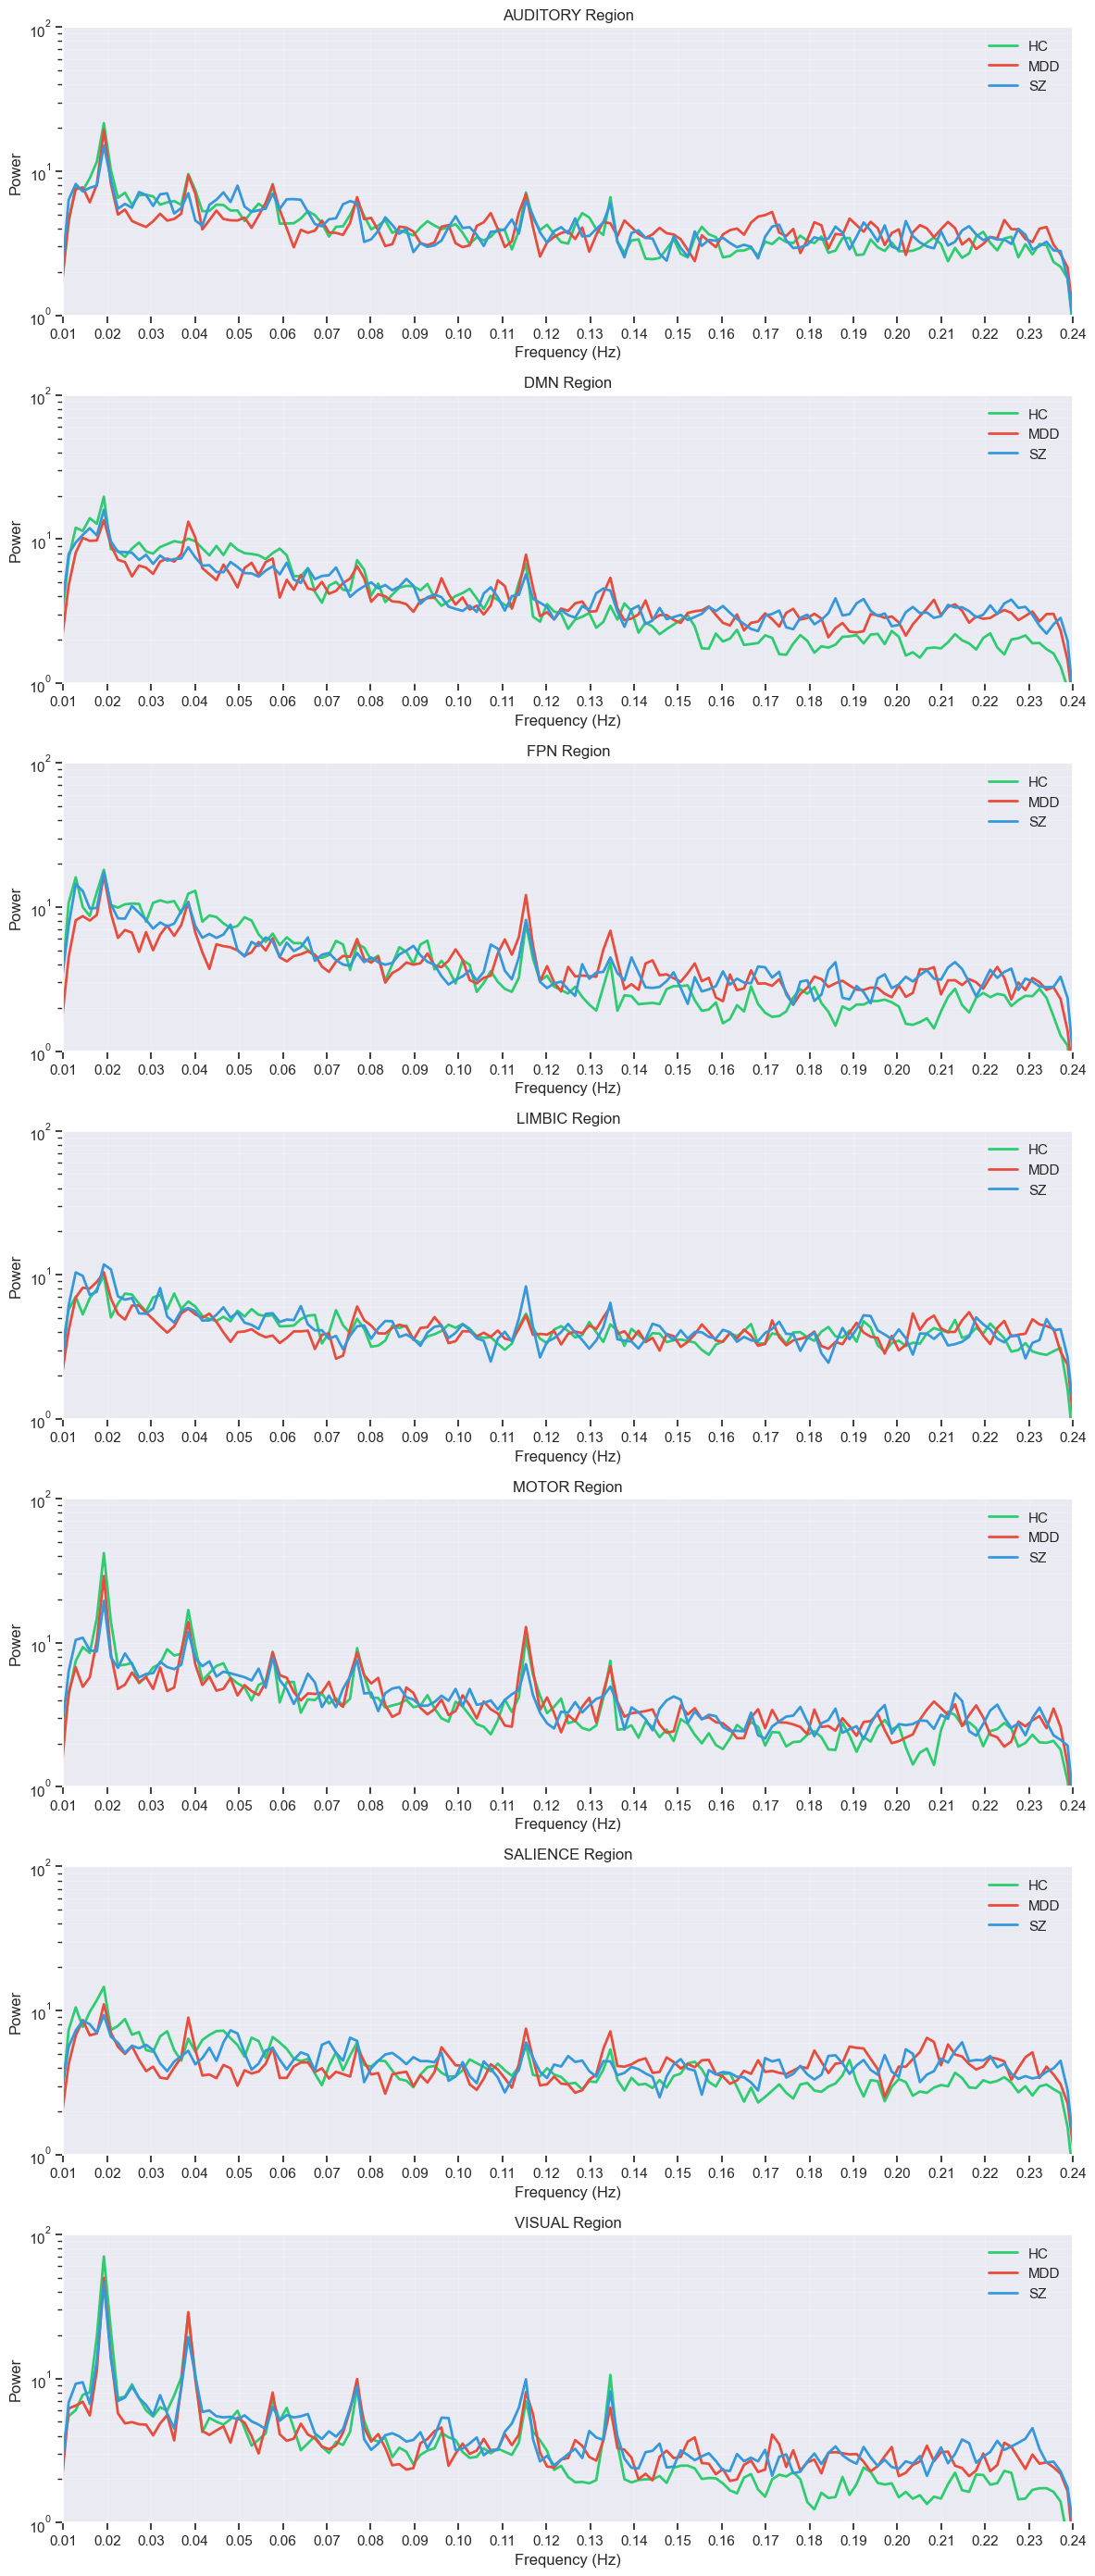

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('seaborn-darkgrid')
sns.set_context("notebook")

# Create a large figure with subplots for each ROI
n_rois = len(mean_spectra['HC'].columns)
fig, axes = plt.subplots(nrows=n_rois, ncols=1, figsize=(12, 4*n_rois))

# Colors for each group
colors = {'HC': '#2ecc71', 'MDD': '#e74c3c', 'SZ': '#3498db'}

# Plot each ROI
for idx, roi in enumerate(mean_spectra['HC'].columns):
    ax = axes[idx]
    
    # Plot each group
    for group in ['HC', 'MDD', 'SZ']:
        spectrum = mean_spectra[group]
        ax.plot(spectrum.index, spectrum[roi], 
                label=group, 
                color=colors[group], 
                linewidth=2)
    
    # Customize each subplot
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_title(f'{roi.upper()} Region')
    ax.legend()
    
    # Set log scale for better visualization of power law decay
    # ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add grid
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Set x-axis limits 
    ax.set_xlim(0.01, 0.24)
    xticks = np.arange(0.01, 0.25, 0.01)
    ax.set_xticks(xticks)

    # Set y-axis limits
    ax.set_ylim(1e-0, 1e2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
# plt.savefig('mean_spectra_by_roi.png', dpi=600, bbox_inches='tight')

**Empirically defined peaks frequency bands**
- 0.125 Hz (8s period)
- 0.03125 Hz (32s period)


**Get power in the target frequency band**
- Feature to select the target frequency
- Feature to select the frequency range around the target frequency
- Feature to select target regions 
- The function should take as input the PSD data and the features to select the target frequency and frequency range and target regions
- The function should return a dataframe with the mean power for each subject and each region for the target frequency and frequency range


In [23]:
# Print all column names to see the exact format
print(df_master.columns.tolist())

['group', 'subject', 'roi', 'freq_0.000000', 'freq_0.001603', 'freq_0.003205', 'freq_0.004808', 'freq_0.006410', 'freq_0.008013', 'freq_0.009615', 'freq_0.011218', 'freq_0.012821', 'freq_0.014423', 'freq_0.016026', 'freq_0.017628', 'freq_0.019231', 'freq_0.020833', 'freq_0.022436', 'freq_0.024038', 'freq_0.025641', 'freq_0.027244', 'freq_0.028846', 'freq_0.030449', 'freq_0.032051', 'freq_0.033654', 'freq_0.035256', 'freq_0.036859', 'freq_0.038462', 'freq_0.040064', 'freq_0.041667', 'freq_0.043269', 'freq_0.044872', 'freq_0.046474', 'freq_0.048077', 'freq_0.049679', 'freq_0.051282', 'freq_0.052885', 'freq_0.054487', 'freq_0.056090', 'freq_0.057692', 'freq_0.059295', 'freq_0.060897', 'freq_0.062500', 'freq_0.064103', 'freq_0.065705', 'freq_0.067308', 'freq_0.068910', 'freq_0.070513', 'freq_0.072115', 'freq_0.073718', 'freq_0.075321', 'freq_0.076923', 'freq_0.078526', 'freq_0.080128', 'freq_0.081731', 'freq_0.083333', 'freq_0.084936', 'freq_0.086538', 'freq_0.088141', 'freq_0.089744', 'fr

In [24]:
def get_frequency_band_data(df, target_freq, freq_range=None, target_regions=None):
    """
    Filter PSD data for specific frequency band and regions.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The master PSD dataframe
    target_freq : float
        The center frequency to analyze
    freq_range : float, optional
        The +/- range around the target frequency. If None, only exact frequency is used.
    target_regions : str or list, optional
        Region(s) of interest to analyze. If None, all regions are included.
    
    Returns:
    --------
    pandas DataFrame
        Filtered dataframe containing only specified regions and frequency columns
    """
    # Handle target regions
    if target_regions is not None:
        if isinstance(target_regions, str):
            target_regions = [target_regions]
        region_mask = df['roi'].isin(target_regions)
    else:
        region_mask = slice(None)  # Select all regions
    
    # Find frequency columns
    if freq_range is not None:
        # Find columns within range
        freq_cols = [col for col in df.columns 
                    if col.startswith('freq_') 
                    and abs(float(col.replace('freq_', '')) - target_freq) <= freq_range]
    else:
        # Find exact frequency match
        freq_col = f'freq_{target_freq:.6f}'
        freq_cols = [freq_col] if freq_col in df.columns else []
        if not freq_cols:
            raise ValueError(f"Exact frequency {target_freq} not found in data")
    
    # Select relevant columns (metadata + frequency columns)
    metadata_cols = ['subject', 'group', 'roi']
    selected_cols = metadata_cols + freq_cols
    
    # Filter the dataframe
    result = df.loc[region_mask, selected_cols]
    
    return result

**Explore the data**
- Select a target frequency
- Compute the mean power for each subject and each region for the target frequency
- Compute the mean power for each group and each region for the target frequency
- Compute the mean power for each group and each region for the target frequency and frequency range
- Return a dataframe for each of the above

In [25]:
def analyze_frequency_band(df, target_freq, freq_range=None, target_regions=None):
    """
    Analyze PSD data for specific frequency bands and regions, computing various aggregations.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The master PSD dataframe
    target_freq : float
        The center frequency to analyze
    freq_range : float, optional
        The +/- range around the target frequency. If None, only target frequency is used.
    target_regions : str or list, optional
        Region(s) of interest to analyze. If None, all regions are included.
    
    Returns:
    --------
    dict of pandas DataFrames
        'subject_level': Mean power per subject and region
        'group_level': Mean power per group and region
        'group_range_level': Mean power per group and region across frequency range
    """
    # Get relevant frequency data
    if freq_range is not None:
        filtered_df = get_frequency_band_data(df, target_freq, freq_range, target_regions)
    else:
        # For single frequency analysis
        freq_col = f'freq_{target_freq:.6f}'
        if isinstance(target_regions, str):
            target_regions = [target_regions]
        region_mask = df['roi'].isin(target_regions) if target_regions else slice(None)
        filtered_df = df.loc[region_mask, ['subject', 'group', 'roi', freq_col]]

    # 1. Subject-level analysis
    subject_level = filtered_df.melt(
        id_vars=['subject', 'group', 'roi'],
        var_name='frequency',
        value_name='power'
    ).groupby(['subject', 'group', 'roi'])['power'].mean().reset_index()

    # 2. Group-level analysis (single frequency)
    group_level = subject_level.groupby(['group', 'roi'])['power'].agg(
        mean_power='mean',
        std_power='std'
    ).reset_index()

    # 3. Group-level analysis (frequency range)
    group_range_level = filtered_df.melt(
        id_vars=['subject', 'group', 'roi'],
        var_name='frequency',
        value_name='power'
    ).groupby(['group', 'roi'])['power'].agg(
        mean_power='mean',
        std_power='std'
    ).reset_index()

    return {
        'subject_level': subject_level,
        'group_level': group_level,
        'group_range_level': group_range_level
    }

**Compute the mean power for each peak**
Identified 6 peaks in the PSD data from visual inspection.



In [31]:
question_frequency = 0.125 # 8s period
results_qfreq = analyze_frequency_band(
    df=df_master,
    target_freq=question_frequency,
)

In [36]:
group_level_qfreq = results_qfreq['group_level']
group_level_qfreq



,group,roi,mean_power,std_power
0,HC,auditory,3.146209,2.069034
1,HC,dmn,2.382937,1.304749
2,HC,fpn,2.509126,1.553079
3,HC,limbic,4.077318,2.069344
4,HC,motor,2.760183,1.600413
5,HC,salience,3.104884,1.850117
6,HC,visual,2.070034,1.337500
7,MDD,auditory,3.845197,2.137713
8,MDD,dmn,3.175732,1.250508
9,MDD,fpn,3.840124,2.428679
